# Player Segmentation Node

For clustering players based on their attributes, we can use *unsupervised machine
learning* algorithms such as K-Means or Hierarchical clustering.

**K-Means** is a popular algorithm for clustering data points into a specified number
 of clusters based on similarity in their attributes. **Hierarchical clustering**, on
  the other hand, creates a hierarchy of clusters and sub-clusters based on the
  similarity of their attributes.

## Which one to use?

To decide which algorithm to use, I considered the size of the dataset
and the desired number of clusters. **K-Means** is computationally faster and efficient
for larger datasets, while **Hierarchical clustering** is suitable for smaller datasets.

The main difference between the two algorithms lies in their approach to form
clusters:

> `K-Means` is a **partition-based** clustering algorithm that groups data points into a
> pre-defined number of clusters. It starts by selecting **random centroids**
> (cluster centers) and then iteratively assigns each data point to the nearest
> centroid based on the distance metric. After all the points are assigned, the
> centroids are updated by taking the mean of all the points in the cluster. The
> algorithm repeats the process until the centroids no longer change, and the
> clusters become stable.

> `Hierarchical clustering` is a **connectivity-based** clustering algorithm that
> does not require a pre-defined number of clusters. It creates a hierarchy of
> clusters by iteratively merging or splitting clusters based on the similarity of
> their attributes. Hierarchical clustering can be performed in **two ways**:
> `agglomerative` and `divisive`. In `agglomerative` clustering, each data point
> starts in its own cluster, and clusters are successively merged until only one
> cluster remains. In `divisive` clustering, all data points start in one cluster,
> and clusters are successively split until each data point is in its own cluster.

To summarize, **K-Means** algorithm partitions the data into a fixed number of clusters
and iteratively optimizes the centroid positions to minimize the distance between
data points and their assigned cluster. **Hierarchical clustering**, on the other hand,
creates a hierarchy of clusters based on the similarity between the data points and
iteratively merges or splits clusters to form the final clusters.

## What can I analyze with the player metadata?

Based on the player metadata, we can use the following criteria to cluster the players:

- `Trophies`: The number of trophies a player has earned in the game is a significant
 indicator of their performance level and skill.
- `3v3 Victories`: This attribute shows how many 3v3 matches the player has won,
which could be an indication of their teamwork ability.
- `Solo Victories and Duo Victories`: These attributes represent how many Solo or Duo
 matches the player has won, indicating their ability to play effectively without the
  support of teammates.
- `Best RoboRumbleTime`: This attribute represents the player's best time in
defeating the robots in the Robo Rumble event, which indicates their skill in
handling PvE (player versus environment) situations.

In [33]:
#import warnings
#warnings.filterwarnings('ignore')

# Set up notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

home_directory = "C:/Users/rober/PycharmProjects/Brawlstars-retention-pipeline"

metadata_prepared = pd.read_csv(
    filepath_or_buffer=home_directory +
                       "/data/03_raw_metadata/metadata_prepared_original.csv"
)

Said this the classification will be performed using a **K-Means** algorithm.

## Data Preparation

Let's start by checking the NaN values

In [34]:
clustered_data = metadata_prepared; clustered_data.head()

,player_id,trophies,highestTrophies,highestPowerPlayPoints,expLevel,expPoints,3vs3Victories,soloVictories,duoVictories,bestRoboRumbleTime
0,#8Y9QGR0U,41103,42113,544.0,247,313184,18746,1332,663,1
1,#99QU9PU2,51754,55004,1204.0,411,858011,64497,900,1132,9
2,#GG9YJJY,21897,35635,1013.0,310,491272,37032,1217,600,0
3,#VJUQ0Y,57372,61076,1380.0,412,862979,63416,1348,780,5
4,#PJGGV2Q80,59129,61757,1362.0,359,654132,48834,558,2838,13


In [35]:
nan_per_col = clustered_data.isna().sum()
print('NAN values per column: ', nan_per_col[nan_per_col > 0])

NAN values per column:  highestPowerPlayPoints    322
dtype: int64


Since `highestPowerPlayPoints` refers to the highest score in a competitive mode
that is no longer active, we will remove it. After all, according to [Brawlstars
Wiki](https://brawlstars.fandom.com/wiki/Power_Play#:~:text=Power%20Play%20Points&text=The%20total%20number%20of%20Power,could%20be%20earned%20is%201386) this competitive mode could be unlocked after earning a Star Power for any Brawler,
meaning that won't be a descriptive attribute for every player.

In [36]:
clustered_data = clustered_data.drop('highestPowerPlayPoints', axis=1)
clustered_data.head()

,player_id,trophies,highestTrophies,expLevel,expPoints,3vs3Victories,soloVictories,duoVictories,bestRoboRumbleTime
0,#8Y9QGR0U,41103,42113,247,313184,18746,1332,663,1
1,#99QU9PU2,51754,55004,411,858011,64497,900,1132,9
2,#GG9YJJY,21897,35635,310,491272,37032,1217,600,0
3,#VJUQ0Y,57372,61076,412,862979,63416,1348,780,5
4,#PJGGV2Q80,59129,61757,359,654132,48834,558,2838,13


Before training a `KMeans` model, it's necessary to prepare the data by scaling it and
selecting the appropriate features. As I mentioned in one on my [experiments](https://github.com/robguilarr/Machine-Learning-Sandbox/blob/master/source/experiments/unsupervised_machine_learning/KMeans.ipynb), in cases when we have
sparse data or features with very different scales, and we want to preserve the
sparsity and relative magnitudes of the data we should use `MaxAbsScaler`, which is a
 scaler that scales each feature by its maximum absolute value.

In [37]:
from sklearn.preprocessing import MaxAbsScaler

X = clustered_data.drop('player_id', axis=1)
y = clustered_data['player_id']

maxAbsScaler = MaxAbsScaler()
X_scaled = maxAbsScaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [38]:
print(len(y) == len(X_scaled))
X_scaled.head()

True


,trophies,highestTrophies,expLevel,expPoints,3vs3Victories,soloVictories,duoVictories,bestRoboRumbleTime
0,0.568357,0.508464,0.494,0.241649,0.147135,0.069242,0.019330,0.05
1,0.715635,0.664107,0.822,0.662031,0.506228,0.046785,0.033004,0.45
2,0.302784,0.430250,0.620,0.379060,0.290659,0.063264,0.017493,0.00
3,0.793318,0.737419,0.824,0.665864,0.497743,0.070073,0.022741,0.25
4,0.817614,0.745641,0.718,0.504721,0.383291,0.029007,0.082743,0.65


## Feature selection

In this case, we'll select the variables that can give us the better
performance given a model construction, this means to test the features that can give
 us the best model performance. So we have to consider 3 options:

- `VarianceThreshold`: This method removes all features whose variance doesn't meet a
certain threshold. This technique is useful when your dataset has many features with
low variance and can be removed without affecting the model's performance.

- `SelectKBest`: This technique selects the K most significant features based on
statistical tests such as chi-squared or ANOVA. You can choose the best K features by
 evaluating the model's performance on a validation set.

- `Recursive Feature Elimination`: This method recursively removes features and
evaluates the model's performance until the optimal number of features is reached.
This method uses a model to assess the feature's importance and removes the least
important ones iteratively.

Said this the most appropiate techniques we should use are `SelectKBest` and
`Recursive Feature Elimination`, but we are going to move for the first one, since
the second one is more compute intensive.

Here we are going to select `n_features_to_select` as 3 to consider the selection of
features to represent:
- Player capacity of earning credits (representation of trophies)
- Capacity of being a team player (representation of 3v3 or Duo victories)
- Solo skills (representation of Solo victories)

The `SelectKBest` function selects the top k features with the highest scores
according to the `f_classif` function, which measures the correlation between the
features and the target variable. `k=3` is specified as the number of top features to
select.

In [39]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=4)

Now let's use the `ColumnTransformer` class and them we pass a list with only one
transformer `SKB_transformer`. Then we specify that the feature selector (`selector` as
 `SelectKBest` instance) will be applied to each one of the columns defined in `X.columns`.

In [40]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('SKB_transformer', selector, X.columns)
])
preprocessor.fit(X_scaled,y)
X_features = preprocessor.transform(X_scaled)

Next, the `get_support()` method is used to get a boolean mask indicating which
features were selected.

The indices of the selected features are extracted using the `indices` argument, and
the corresponding column names are extracted using pandas indexing.

In [41]:
# Get index number of new feature-selected data
new_columns_index = preprocessor.named_transformers_['SKB_transformer'].get_support(indices=True)
# Get column names of new feature-selected data
new_columns_names = (clustered_data.drop('player_id', axis=1)
                     .iloc[:, new_columns_index]
                     .columns)
# Create dataframe with subset of features
X_features = pd.DataFrame(X_features, columns=new_columns_names)
X_features.head()

,expPoints,3vs3Victories,soloVictories,duoVictories
0,0.241649,0.147135,0.069242,0.019330
1,0.662031,0.506228,0.046785,0.033004
2,0.379060,0.290659,0.063264,0.017493
3,0.665864,0.497743,0.070073,0.022741
4,0.504721,0.383291,0.029007,0.082743


Now let's train the model, we first need to instantiate the KMeans class from
scikit-learn, and specify the number of clusters `(n_clusters)` and other
hyperparameters.

Let's also consider the application of multiple hyperparameters, to select the number
 of clusters that produce the maximum score number.

In [45]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

params = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "init": ["k-means++", "random"],
    "max_iter": [100],
    "tol": [0.001, 0.01]
}

grid_search = GridSearchCV(KMeans(random_state=42), param_grid=params, cv=5)
grid_search.fit(X_features)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.2f}")

Best Parameters: {'init': 'random', 'max_iter': 100, 'n_clusters': 10, 'tol': 0.001}
Best Score: -39.32


Also we can study the inertia between points and clusters

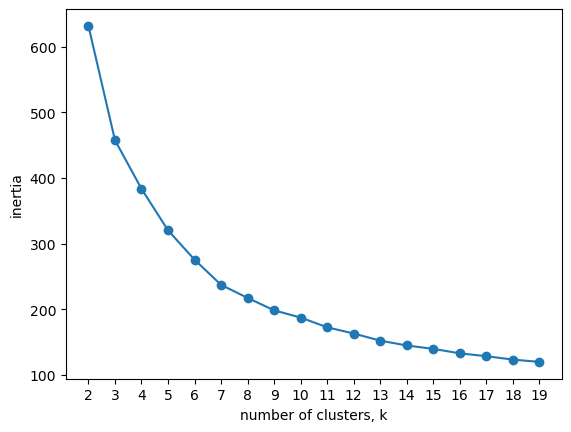

In [43]:
ks = range(2, 20)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=42)

    # Fit model to samples
    model.fit(X_features)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [44]:
#import matplotlib.pyplot as plt

#centroids = kmeans.cluster_centers_
#centroids_x = centroids[:,4]
#centroids_y = centroids[:,5]

#ys = maxAbsScaler.fit_transform(clustered_data["soloVictories"].values.reshape(-1,1))
#xs = maxAbsScaler.fit_transform(clustered_data["3vs3Victories"].values.reshape(-1,1))
#plt.scatter(xs, ys, c=labels, alpha=0.1)

#plt.scatter(centroids_x, centroids_y, marker='D', s=50, c= 'red')
#plt.show()

## Conclussions

After clustering the players, we can draw conclusions about their performance, skill
level, and the game mode in which they excel.

For example, if a particular cluster has players with high trophies, 3vs3 victories,
and best RoboRumbleTime, they could be classified as highly skilled players with good
 teamwork and PvE abilities. Similarly, a cluster with players having high solo and
 duo victories could be classified as excellent solo and duo players.

Overall, clustering can help you understand player behavior and preferences, and we
can use these insights to improve the game experience for the players.